In [78]:
import re
import numpy as np
import pandas as pd
from tqdm import tqdm, trange
import math
from functools import reduce

# импортируем библиотеку matplotlib для построения графиков
import matplotlib.pyplot as plt
%matplotlib inline

# задаем некоторые настройки pandas, регулирующие
# формат вывода
pd.set_option('display.notebook_repr_html', True)
pd.set_option('display.max_columns', 10)
pd.set_option('display.max_rows', 50)
pd.set_option('display.width', 500)

In [114]:
clean_lines = []
with open('oz.txt', 'r') as oz_file:
    lines = oz_file.readlines()
    full_text = "".join(lines)
    # так как в файле содержатся пустые строки, необходимо произвести чистку
    # в некоторых абзацах имеются несколько предложений, формируем список единичных предложений
    clean_lines.extend(reduce(lambda itemA, itemB: itemA + itemB,
                              [line.strip().split(". ") for line in lines if line != '\n']))
    
symbols = "«»:;,./?\"1234567890!$#@^&*=+\-~<>{}[]()-–_ …"    
words_dict = {}
total_words = 0
# формируем чистый сет
for line in clean_lines:
    '''
        убрали символы сначала иконца строки
        перевели все в нижний регистр
        разделили на слова
    '''
    words_line = line.strip().lower().split()
    local_list = [i.strip(symbols) for i in words_line]
    total_words += len(local_list)
    buffer_lines.append(local_list)
    # делаем сет из уникальных возможных слов
    for word in local_list:
        if (word != ""):
            words_dict[word] = words_dict.get(word, 0) + 1
            
print("Общее количество символов : ", len(full_text))
print("Общее количество предложений : ", len(clean_lines))
print("Общее количество слов : ", total_words)
print("Общее количество уникальных слов : ", len(words_dict.keys()))

Общее количество символов :  205686
Общее количество предложений :  2925
Общее количество слов :  33376
Общее количество уникальных слов :  8015


### Задача - так как  оценить работу одного алгоритма формирования корпуса слов невозможно без учета семантики слов, я решил сравнить два алгоритма по производительности и точности. Точность определял своим экспертным мнением.

In [115]:
# описал функцию Левенстейна
def levenstein_distance(wordA, wordB):
    i_weight = 1
    r_weight = 1
    d_weight = 1
    distance = np.zeros((len(wordA), len(wordB)))
    for j in range(1, len(wordB)):
        distance[0][j] = distance[0][j-1] + i_weight
    for i in range(1, len(wordA)):
        distance[i][0] = distance[i-1][0] + d_weight
        for j in range(1, len(wordB)):
            distance[i][j] = min(distance[i-1][j] + d_weight,
                                 distance[i][j-1] + i_weight,
                                 distance[i-1][j-1] + (0 if wordA[i-1] == wordB[j-1] else 1))        
    return distance[len(wordA)-1][len(wordB)-1]

def merge_words_levenstein(words_dict, max_error = 0.2, words_limit = 0):
    local_words_dict = words_dict.copy()
    words_list = list(local_words_dict.keys())
    # определяем количество  слов в выборке
    num_unique_words = len(words_list) if words_limit == 0 else words_limit
    merged_words = {}
    # первый цикл делает проход по всем словам из указанной выборки
    for i in trange(num_unique_words):
        wordA = words_list[i]
        '''
            для  оптимизации алгоритма проверяю небыло ли слово уже объеденено с другими,
            также вероятность ошибки на словах длинны меньше 4 символов слишком велика (рассуждая логически),
            поэтому я исключил их из сравнения
        '''    
        if wordA == 'PASS' or len(wordA) <= 3:
            continue
        # для оптимизации работы алгоритма формирую список слов для сравнения со словом wordA каждый новый виток цикла    
        updated_list = list(local_words_dict.keys())
        for j in range(len(updated_list)):
            wordB = updated_list[j]
            # исходя из коэффициента ошибки и длинн слов рассчитываю максимально допустимое расстояние
            max_allowed_distance = min(round(len(wordA) * max_error),
                                        round(len(wordB) * max_error))

            # длинна слова Б должна быть больше 3 символом и оно не совпадает со словом А
            if (len(wordB) > 3 and wordA != wordB):
                # рассчитали расстояние по Левенштейну
                distance = levenstein_distance(wordA, wordB)
                if (distance <= max_allowed_distance):
                    # если расстояние допустимое - сливаем слова и помечаем его в  главной выборке как отработанное 
                    words_list[words_list.index(wordB)] = 'PASS'
                    local_words_dict[wordA] += local_words_dict[wordB]
                    del local_words_dict[wordB]
                    if (wordA in merged_words):
                        merged_words[wordA].append(wordB)
                    else:
                        merged_words[wordA] = [wordB]
    # формируем словарь где ключ - это слово, а значение - список из количества вхождений всех слов из этой группы и объедененных слов                  
    full_merged_dict = {word:[local_words_dict[word], merged_words.get(word, [])] for word in local_words_dict.keys()}                    
    return full_merged_dict

In [116]:
# пробуем функцию Левенштейна на выборке 100 слов с коэффициенттом ошибки 0.2
levenstein_words_dict = merge_words_levenstein(words_dict, 0.2, 100)

# формирует дата сет результатов
levenstein_df = pd.DataFrame(list(levenstein_words_dict.values()),
                             columns=['count', 'levenstein merged'],
                             index=levenstein_words_dict.keys())
print(levenstein_df.head())

100%|██████████| 100/100 [00:50<00:00,  1.86it/s]

            count                                  levenstein merged
ураган         15                                 [ураганы, урагана]
среди          19                                     [следу, сведу]
обширной        2                                                 []
канзасской      3                                                 []
степи          24  [степь, стена, стену, стены, стене, степью, ст...


In [117]:
# данный алгорит разрабатывал самостоятельно

def vectorize_letters(words):
    # данная функция проходит по всем словам из переданной выборки для формирования сета уникальных символов
    letters_set = {letter for letter in reduce(lambda a,b : a + b if b not in a else a, words)} 
    letters_list = list(letters_set)
    number_of_letters = len(letters_list)
    # используя полученный сет и его  длинну  формируем словарь векторов с 0 и 1 для каждой буквы соответственно
    letters_dict = {letter:[1. if index == letters_list.index(letter) else 0. for index in range(number_of_letters)] for letter in letters_set}
    # так как длинны слов различны, необходимо создать пустой вектор для последующих операций
    letters_dict['empty'] = [0. for i in range(number_of_letters)]
    return letters_dict

# векторизуем все символы из выборки слов
letters_vector_dict = vectorize_letters(list(words_dict.keys()))
#  определяем  максимальную длинну слова
max_word_length = len(reduce(lambda a,b: a if len(a) > len(b) else b, words_dict.keys()))

def to_vect(word, end_size = max_word_length):
    # данная  функция конвертирует слово в вектор-строку последовательно добавляя вектора каждой буквы
    # также добавляя пустой  вектор в конец, если длина слова меньше максимальной длинны
    # это необходимо для корректных последующих вычислений длинн и произведений векторов
    word_to_vect = []
    for i in range(end_size):
        letter = word[i] if len(word) > i else 'empty'
        word_to_vect.extend(letters_vector_dict[letter].copy())
    return word_to_vect  

def vect_len(vector):
    # определяем длинну вектора
    sumb = 0
    for i in vector:
        sumb += i**2
    return math.sqrt(sumb) 

def vect_angle(vect1, vect2):
    # определяем угол между векторами по формулам из школьной математики
    vect1_len = vect_len(vect1)
    vect2_len = vect_len(vect2)
    vect_mult = np.dot(vect1, vect2)
    cos_a = vect_mult / (vect1_len * vect2_len)
    cos_a = 1 if cos_a > 1 else cos_a
    alpha = math.acos(cos_a)
    return alpha

def merge_words_vectorizing(words_dict, max_error_angle = 0.5, words_limit = 0):
    # в целом данный алгоритм идентичен предыдущему, заисключением  критерия сравнений
    local_words_dict = words_dict.copy()
    words_list = list(local_words_dict.keys())
    # определяем количество  слов в выборке
    num_unique_words = len(words_list) if words_limit == 0 else words_limit
    merged_words = {}
    # формирую словарь векторов всех слов дабы не делать эту работу на каждом ветке
    vectors_dict = {word:to_vect(word) for word in local_words_dict.keys()}
    # первый цикл делает проход по всем словам из указанной выборки
    for i in trange(num_unique_words):
        wordA = words_list[i]
        '''
            для  оптимизации алгоритма проверяю небыло ли слово уже объеденено с другими,
            также вероятность ошибки на словах длинны меньше 4 символов слишком велика (рассуждая логически),
            поэтому я исключил их из сравнения
        '''  
        if wordA == 'PASS' or len(wordA) <= 3:
            continue
        # для оптимизации работы алгоритма формирую список слов для сравнения со словом wordA каждый новый виток цикла    
        updated_list = list(local_words_dict.keys())
        for j in range(len(updated_list)):
            wordB = updated_list[j]
            # длинна слова Б должна быть больше 3 символом и оно не совпадает со словом А
            if (len(wordB) > 3 and wordA != wordB):
                # рассчитываем угол между  векторами двух слов
                error_angle = vect_angle(vectors_dict[wordA], vectors_dict[wordB])
                if (error_angle <= max_error_angle):
                    # если угол между веторами соответствует критерию, объединяем слова
                    words_list[words_list.index(wordB)] = 'PASS'
                    local_words_dict[wordA] += local_words_dict[wordB]
                    del local_words_dict[wordB]
                    del vectors_dict[wordB]
                    if (wordA in merged_words):
                        merged_words[wordA].append(wordB)
                    else:
                        merged_words[wordA] = [wordB]
    # формируем словарь где ключ - это слово, а значение - список из количества вхождений всех слов из этой группы и объедененных слов                  
    full_merged_dict = {word:[local_words_dict[word], merged_words.get(word, [])] for word in local_words_dict.keys()}                    
    return full_merged_dict                    

In [118]:
# пробуем векторное сравнение на выборке 100 слов с допустимым углом 0.65
vectorizing_words_dict = merge_words_vectorizing(words_dict, 0.65, 100)

# формирует дата сет результатов
vectorizing_df = pd.DataFrame(list(vectorizing_words_dict.values()),
                             columns=['count', 'vectorizing merged'],
                             index=vectorizing_words_dict.keys())
print(vectorizing_df.head())

100%|██████████| 100/100 [01:01<00:00,  1.62it/s]

            count                                 vectorizing merged
ураган         21  [ураганный, ураганы, урагана, ураганов, ураганом]
среди          16                                                 []
обширной        2                                                 []
канзасской      3                                                 []
степи           7                                            [степь]


In [48]:
# формируем корпусы слов двумя  алгоритмами для полной выборки
levenstein_words_dict = merge_words_levenstein(words_dict, 0.2)
vectorizing_words_dict = merge_words_vectorizing(words_dict, 0.65)

print("Количество уникальных слов по Левенштейну :", len(levenstein_words_dict.keys()))
print("Количество уникальных слов по векторам :", len(vectorizing_words_dict.keys()))

# для наглядности создаем словарь используя все начальные слова, помечая их как объединенные для каждого алгоритма
full_dict = {word:[levenstein_words_dict.get(word, [0])[0],
                   levenstein_words_dict.get(word, [0, '---MERGED---'])[1],
                   vectorizing_words_dict.get(word, [0])[0],
                   vectorizing_words_dict.get(word, [0, '---MERGED---'])[1]] for word in words_dict.keys()}

# создаем общий датасет с результатами двух алгоритмов
full_df = pd.DataFrame(list(full_dict.values()),
                             columns=['L. Count', 'L. Merged', 'V. Count', 'V. Merged'],
                             index=full_dict.keys())
full_df.head()

100%|██████████| 8015/8015 [55:54<00:00,  2.38it/s]  

Количество уникальных слов по Левенштейну : 3590
Количество уникальных слов по векторам : 5446


,L. Count,L. Merged,V. Count,V. Merged
ураган,15,"[ураганы, урагана]",21,"[ураганный, ураганы, урагана, ураганов, ураганом]"
среди,19,"[следу, сведу]",16,[]
обширной,2,[],2,[]
канзасской,3,[],3,[]
степи,24,"[степь, стена, стену, стены, стене, степью, ст...",7,[степь]


### по  результатам работы алгоритмов  делаем вывод что алгоритм Левенштейна ужимает корпус слов сильнее,  однако допускает большое количество смысловых ошибок. Результат работы алгоритма с использованием веторов работает гораздо точнее. Однако у него есть минут - это затраченное время. Он выполняется практически в 2 раза дольше.###

In [49]:
# для персональной оценки выводим только те слова, которые были обработаны алгоритмами по разному
full_df[full_df['L. Count'] != full_df['V. Count']]

,L. Count,L. Merged,V. Count,V. Merged
ураган,15,"[ураганы, урагана]",21,"[ураганный, ураганы, урагана, ураганов, ураганом]"
среди,19,"[следу, сведу]",16,[]
степи,24,"[степь, стена, стену, стены, стене, степью, ст...",7,[степь]
жила,47,"[жили, мили, силы, сила, жаль, силу, била, жал...",3,[жилам]
девочка,0,---MERGED---,95,"[девочкой, девочке, девочку, девочки]"
отец,28,"[хотел, ответ, одет, отцу]",5,[]
фермер,11,"[фермера, фермеры, фермы]",9,"[фермера, фермеры]"
джон,21,"[джона, двор, двое, дров]",8,[джона]
целый,28,"[белых, целая, целых, целую, белые, целые, цел...",17,"[целых, целые, целой, белый, целым]"
день,223,"[деле, меня, дело, дела, дети, жена, деву, дев...",25,[]


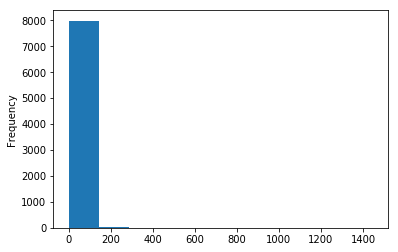

In [129]:
full_df['L. Count'].plot('hist')

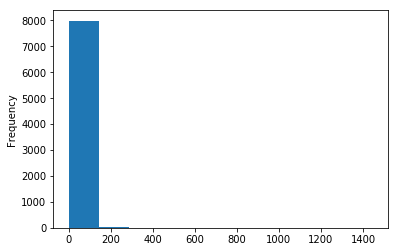

In [130]:
full_df['V. Count'].plot('hist')

In [128]:
# из графиков видно что емеется явно выраженный пик для каких-то из слов
# посмотрим на эти слова
full_df[full_df['V. Count'] >= 100]

,L. Count,L. Merged,V. Count,V. Merged
элли,487,[],487,[]
её,145,[],145,[]
в,645,[],645,[]
по,121,[],121,[]
они,113,[],113,[]
с,379,[],379,[]
и,1447,[],1447,[]
на,497,[],497,[]
у,175,[],175,[]
не,560,[],560,[]
